# Feature extraction 
- x using autoencoder
- Using Latent vector of DNN classifier

## Init

In [15]:
# !pip install sentencepiece

In [16]:
# !pip install datasets evaluate transformers[sentencepiece]

In [17]:
import timm
import numpy as np
import torch
import matplotlib.pyplot as plt
import transformers
import pandas as pd
import seaborn as sns
from transformers import pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from PIL import Image

In [18]:
cd imagenet-autoencoder/

[WinError 2] The system cannot find the file specified: 'imagenet-autoencoder/'
c:\Users\seung\Desktop\auto_image\Mixed-AutoEncoder\imagenet-autoencoder


In [19]:
#creating dataset
!python tools/generate_list.py --name weather_test --path ../dataset

In [20]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
label = data['class']
num_class = len(data['class'].unique())
names = ['fire','fogsmog', 'lightning', 'rain', 'sandstorm','snow']
data['name'] = [names[i] for i in data['class']]

C:\Users\seung\AppData\Local\Temp\ipykernel_5784\228420673.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


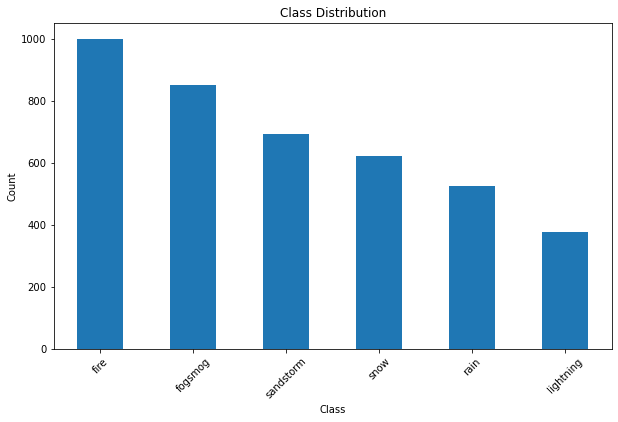

In [21]:
class_counts = data['name'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
model_name = timm.list_models()
for names in model_name:
    if "vit" in names:
        print(names)

convit_base
convit_small
convit_tiny
crossvit_9_240
crossvit_9_dagger_240
crossvit_15_240
crossvit_15_dagger_240
crossvit_15_dagger_408
crossvit_18_240
crossvit_18_dagger_240
crossvit_18_dagger_408
crossvit_base_240
crossvit_small_240
crossvit_tiny_240
davit_base
davit_giant
davit_huge
davit_large
davit_small
davit_tiny
flexivit_base
flexivit_large
flexivit_small
gcvit_base
gcvit_small
gcvit_tiny
gcvit_xtiny
gcvit_xxtiny
levit_128
levit_128s
levit_192
levit_256
levit_256d
levit_384
levit_384_s8
levit_512
levit_512_s8
levit_512d
levit_conv_128
levit_conv_128s
levit_conv_192
levit_conv_256
levit_conv_256d
levit_conv_384
levit_conv_384_s8
levit_conv_512
levit_conv_512_s8
levit_conv_512d
maxvit_base_tf_224
maxvit_base_tf_384
maxvit_base_tf_512
maxvit_large_tf_224
maxvit_large_tf_384
maxvit_large_tf_512
maxvit_nano_rw_256
maxvit_pico_rw_256
maxvit_rmlp_base_rw_224
maxvit_rmlp_base_rw_384
maxvit_rmlp_nano_rw_256
maxvit_rmlp_pico_rw_256
maxvit_rmlp_small_rw_224
maxvit_rmlp_small_rw_256
maxvit

## Hugging Face - feature extraction pipline

### Init

In [22]:
transformers.__version__

'4.40.1'

In [23]:
pipeline.__annotations__

{'task': str,
 'model': typing.Union[str, ForwardRef('PreTrainedModel'), ForwardRef('TFPreTrainedModel'), NoneType],
 'config': typing.Union[str, transformers.configuration_utils.PretrainedConfig, NoneType],
 'tokenizer': typing.Union[str, transformers.tokenization_utils.PreTrainedTokenizer, ForwardRef('PreTrainedTokenizerFast'), NoneType],
 'feature_extractor': typing.Union[str, ForwardRef('SequenceFeatureExtractor'), NoneType],
 'image_processor': typing.Union[str, transformers.image_processing_utils.BaseImageProcessor, NoneType],
 'framework': typing.Optional[str],
 'revision': typing.Optional[str],
 'use_fast': bool,
 'token': typing.Union[bool, str, NoneType],
 'device': typing.Union[int, str, ForwardRef('torch.device'), NoneType],
 'trust_remote_code': typing.Optional[bool],
 'model_kwargs': typing.Dict[str, typing.Any],
 'pipeline_class': typing.Optional[typing.Any],
 'return': transformers.pipelines.base.Pipeline}

In [24]:
class pca_estimation():
    def __init__(self, input_vector, label):
        self.input_vector = input_vector
        self.label = label
    def evaluate_pca(self):
        pca=PCA()
        pca.fit(self.input_vector)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        
    def kmeans_with_pca(self,num_components, num_cluster):
        pca_test = PCA(n_components=num_components)
        latent_vector = pca_test.fit_transform(self.input_vector)
        kmeans = KMeans(n_clusters = num_cluster)
        y_kmeans = kmeans.fit_predict(latent_vector)
        conf_matrix = confusion_matrix(self.label, y_kmeans)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted Label')
        plt.ylabel('class')

In [27]:
# Read Images
image_list = list()
for path in data['path']:
    image = Image.open(path)
    image_list.append(image)
len(image_list)

4067

### ViT224

In [29]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_224= pipeline(task="image-feature-extraction", model_name="vit_base_patch16_224", device=DEVICE, pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
#Start Inference
outputs = pipe_224(image_list)
#Change shapes 
np_output = np.array(outputs)
reshaped_otuput = np_output.reshape((np_output.shape[0],-1))
reshaped_otuput.shape

(4067, 768)

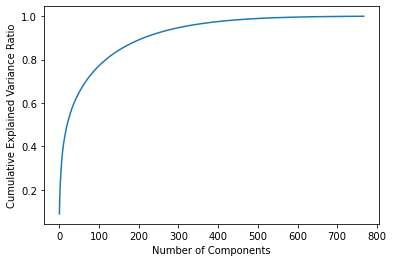

In [27]:
vit_pca = pca_estimation(reshaped_otuput, label)
vit_pca.evaluate_pca()

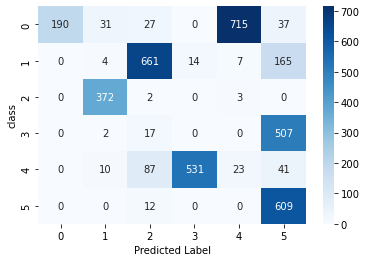

In [28]:
vit_pca.kmeans_with_pca(700,num_cluster = num_class)

### ViT 384

In [28]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')



C:\Users\seung\AppData\Roaming\Python\Python39\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [31]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_384= pipeline(task="image-feature-extraction",image_processor=feature_extractor, model = model, device=DEVICE)

In [32]:
#Start Inference
o4 = pipe_384(image_list)
#Change shapes 
o4 = np.array(o4)
o4 = o4.reshape((o4.shape[0],-1))
o4.shape

(4067, 1000)

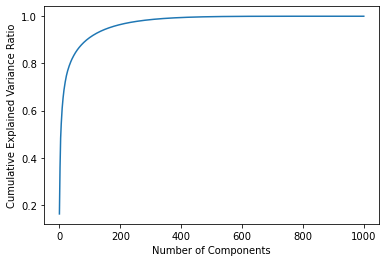

In [34]:
vit_384_pca = pca_estimation(o4, label)
vit_384_pca.evaluate_pca()

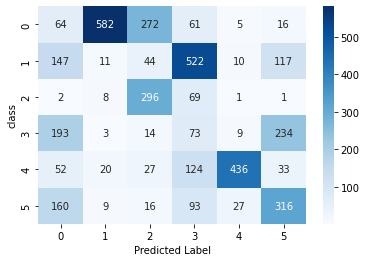

In [38]:
vit_384_pca.kmeans_with_pca(550,num_cluster=num_class)

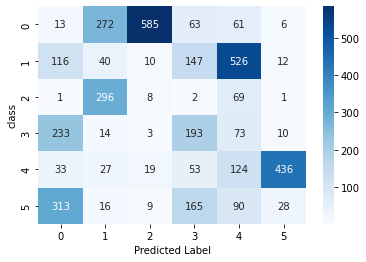

In [40]:
vit_384_pca.kmeans_with_pca(1000,num_cluster=num_class)

#### standard test

In [109]:
o4.shape

(4067, 1000)

In [115]:
tt = o4

In [120]:
max_row = np.max(o4, axis = 0)
min_row = np.min(o4, axis = 0)
col_data = []
for item in tt:
    col_data.append((item - min_row)/(max_row - min_row))
col_data = np.array(col_data).reshape((o4.shape))

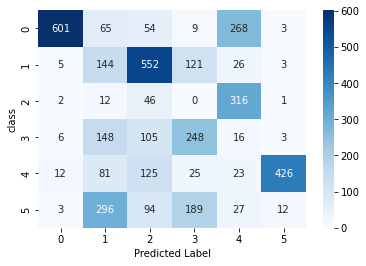

In [138]:
vit_384_pca_1= pca_estimation(col_data, label)
# vit_384_pca_1.evaluate_pca()
vit_384_pca_1.kmeans_with_pca(700,num_cluster=num_class)    

### efficient net

In [64]:
model.config

ResNetConfig {
  "_name_or_path": "microsoft/resnet-152",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Pas

In [70]:
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification


preprocessor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")

preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

C:\Users\seung\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\seung\.cache\huggingface\hub\models--google--efficientnet-b0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [75]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_eff_224 = pipeline(task="image-feature-extraction",image_processor = preprocessor, model = model, device=DEVICE)

In [76]:
#Start Inference
o2 = pipe_eff_224(image_list)
#Change shapes 
o2 = np.array(o2)
o2 = o2.reshape((o2.shape[0],-1))
o2.shape

(4067, 1000)

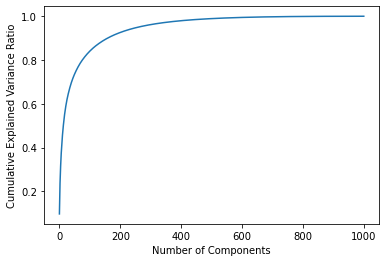

In [77]:
eff_pca = pca_estimation(o2, label)
eff_pca.evaluate_pca()

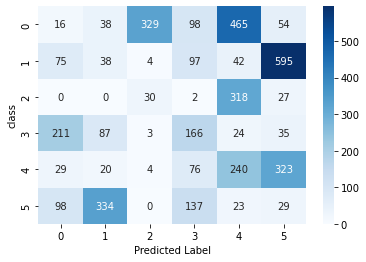

In [78]:
eff_pca.kmeans_with_pca(num_components=o2.shape[1], num_cluster = num_class)

### Resnet152

In [79]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from datasets import load_dataset


feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-152")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-152")

C:\Users\seung\AppData\Roaming\Python\Python39\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [82]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_res_224 = pipeline(task="image-feature-extraction",image_processor = preprocessor, model = model, device=DEVICE)

In [83]:
#Start Inference
o3 = pipe_res_224(image_list)
#Change shapes 
o3 = np.array(o3)
o3 = o3.reshape((o3.shape[0],-1))
o3.shape

(4067, 1000)

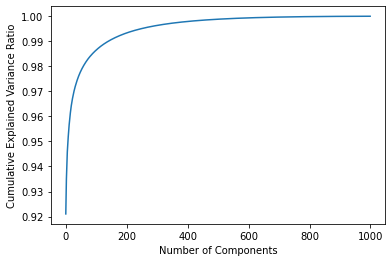

In [84]:
res_pca = pca_estimation(o3, label)
res_pca.evaluate_pca()

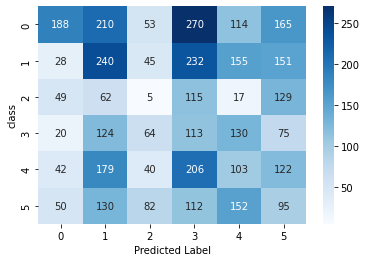

In [85]:
res_pca.kmeans_with_pca(o3.shape[1],num_cluster=num_class)

### SwinTransformer

In [42]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [43]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_swin_224 = pipeline(task="image-feature-extraction",image_processor = processor, model = model, device=DEVICE)

In [44]:
#Start Inference
o5 = pipe_swin_224(image_list)
#Change shapes 
o5 = np.array(o5)
o5 = o5.reshape((o5.shape[0],-1))
o5.shape

(4067, 1000)

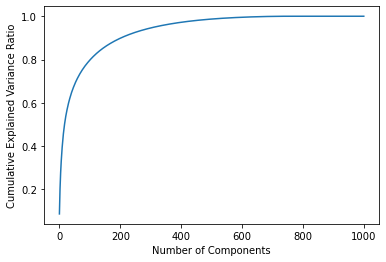

In [46]:
swin_pca = pca_estimation(o5, label)
swin_pca.evaluate_pca()

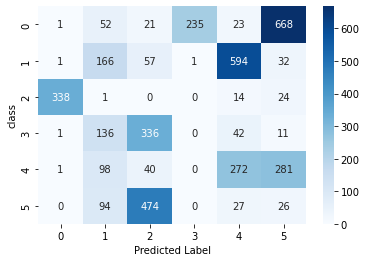

In [49]:
swin_pca.kmeans_with_pca(num_components=600, num_cluster = num_class)

### MLP-MIXER

In [ ]:
model = timm.create_model('mixer_b16_224.goog_in21k', pretrained=True)

In [ ]:
target_layer = "norm"

In [ ]:
modules

In [61]:
modules = list(model.children())

# 선택한 레이어까지의 모듈 중에서 선택한 레이어까지의 인덱스 찾기
selected_layer_index = None
for idx, module in enumerate(modules):
    if hasattr(module, target_layer):
        selected_layer_index = idx

if selected_layer_index is None:
    raise ValueError(f"Selected layer '{target_layer}' not found in the model.")

# 선택한 레이어까지의 모듈로 새로운 모델 생성
model = torch.nn.Sequential(*modules[:selected_layer_index + 1])

In [68]:
model

MlpMixer(
  (stem): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): Sequential(
    (0): MixerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp_tokens): Mlp(
        (fc1): Linear(in_features=196, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=384, out_features=196, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp_channels): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      

In [59]:
tt = torch.rand(1,3,224,224)
o = model(tt)
o.shape

torch.Size([1, 196, 21843])

In [37]:
target_layer = "norm"
# model = torch.nn.Sequential(*list(model.children())[:model.index(target_layer) + 1])

In [31]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_swin_224 = pipeline(task="image-feature-extraction",image_processor =   transforms,config=data_config, model = model, device=DEVICE, )

AttributeError: 'MlpMixer' object has no attribute 'config'